Multicollinearity is where 3 or more features are highly correlated.  I am going to demonstrate how to calculate when you are experiencing multicollinearity using variance inflation factor (VIF).

To start I am going to use sklearn to make a dataset. 

In [1]:
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
np.random.seed(11)

In [2]:
X, y = make_regression(n_features = 10, noise=10, random_state=11, )
df = pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'])
df['Y'] = y

I am going to create a new feature that is a combination of the other features. 

In [3]:
df['X11'] = df['X1'] - df['X2'] + df['X3'] + np.random.normal(scale = 15)

Now lets look at the correlation heat map to see if there is any highly correlated features. 

In [4]:
import seaborn as sns 
sns.heatmap(df.corr(), vmin = -1, vmax = 1)

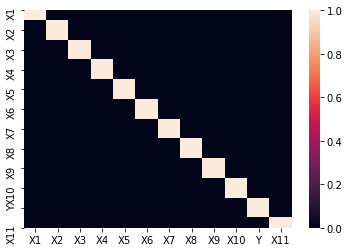

In [5]:
sns.heatmap(np.abs(df.corr()) > 0.7)

We see that none of the features have a correlation above 0.70 or below -0.70.  Next, I am going to use VIF to determine if I am experiencing multicollinearity. 

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

Note: per this [open issue](https://github.com/statsmodels/statsmodels/issues/2376) on variance inflation factor you need to add a constant variable to your dataframe.   

In [8]:
import statsmodels.api as sm

df = sm.add_constant(df)

/Users/jeffreyherman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


I am going to test out all the features to see what the VIF value is.  I am skipping the first feature (the intercept term). 

In [9]:
for i in range(1, 12):
    print(f'{df.drop("Y", axis = 1).columns[i]} {variance_inflation_factor(df.drop("Y", axis = 1).values, i)}')

X1 inf
X2 inf
X3 inf
X4 1.0410536144535685
X5 1.0917593842615227
X6 1.0955635908289258
X7 1.0425296201253647
X8 1.1118123228822059
X9 1.0514883476308678
X10 1.1173223003485162
X11 inf


/Users/jeffreyherman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


I see I have multiple features that have a VIF value of `inf`.  Lets see what is causing that. 

Below is the formula for how VIF is calculated. 

$$ VIF = \frac{1}{1 - R^2} $$ 

From above, I got a VIF of `inf` for `X1`.  To calculate VIF for `X1` - I am going to build a regression using all the independent variables except for `X1` and use those features to predict `X1`. 

In [10]:
X = df.drop(['X1', 'Y'], axis = 1)
Y = df['X1']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     X1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.619e+27
Date:                Tue, 28 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:04:25   Log-Likelihood:                 2885.6
No. Observations:                 100   AIC:                            -5749.
Df Residuals:                      89   BIC:                            -5720.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2418   2.17e-13  -1.21e+14      0.000     -26.242     -26.242
X2             1.0000   1.13e-14   8.82e+13      0.000       1.000       1.000
X3            -1.0000   1.06e-14  -9.43e+13      0.000      -1.000      -1.000
X4         -6.245e-16   7.43e-15     -0.084      0.933   -1.54e-14    1.41e-14
X5          -4.51e-17   8.15e-15     -0.006      0.996   -1.62e-14    1.62e-14
X6           2.22e-16   8.73e-15      0.025      0.980   -1.71e-14    1.76e-14
X7         -5.925e-16   7.58e-15     -0.078      0.938   -1.56e-14    1.45e-14
X8          7.494e-16   7.56e-15      0.099      0.921   -1.43e-14    1.58e-14
X9         -1.638e-15   7.95e-15     -0.206      0.837   -1.74e-14    1.41e-14
X10        -4.996e-16   7.58e-15     -0.066      0.948   -1.56e-14    1.46e-14
X11            1.0000   8.26e-15   1.21e+14      0.000       1.000       1.000
==============================================================================
Omnibus:                        0.866   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.648   Jarque-Bera (JB):                0.981
Skew:                           0.178   Prob(JB):                        0.612
Kurtosis:                       2.669   Cond. No.                         761.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I see that I get a perfect R^2.  So plugging this into my VIF formula 

$$ VIF = \frac{1}{1 - 1} $$ 

This is where the `inf` comes from.  I have a problem because I am able to perfectly predict `X1` from the other features.  

If we remember, we have 4 features with a `VIF` of `inf`.  I am going to first drop `X1` and see what my new VIF scores are. 

In [11]:
for i in range(1, 12):
    print(f'{df.drop([]"Y", axis = 1).columns[i]} {variance_inflation_factor(df.drop("Y", axis = 1).values, i)}')

X1 inf
X2 inf
X3 inf
X4 1.0410536144535685
X5 1.0917593842615227
X6 1.0955635908289258
X7 1.0425296201253647
X8 1.1118123228822059
X9 1.0514883476308678
X10 1.1173223003485162
X11 inf


In [252]:
df.drop(['Y', 'X11'], axis = 1, inplace = True)
for i in range(1, 11):
    print(f'{df.columns[i]} {variance_inflation_factor(df.values, i)}')

X1 1.1056812354246772
X2 1.0741738574018993
X3 1.0836168289787529
X4 1.0410536144535685
X5 1.0917593842615227
X6 1.0955635908289256
X7 1.0425296201253647
X8 1.1118123228822059
X9 1.051488347630868
X10 1.1173223003485164


Now, I see that I get value for each of the 10 features.  We typically use a threshold of either below 5 or below 10 as a good VIF.  A VIF of 5 means that the other features are able to predict that feature with a R^2 of 0.80.  A VIF of 10 means that the other features are able to predict that feature with a R^2 of 0.90.  